In [1]:
source("qa_plot_functions.R")
library(reshape2)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths



## Download the pheno data to get ratings and other relevant info

### Lets get the pheno file directly from the Internets!

In [2]:
pheno_df<-read.csv("http://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE/Phenotypic_V1_0b_preprocessed1.csv")

### Conform the names of the raters and their ratings


In [3]:
#conform the names of the raters and their ratings
rater_cols <- setdiff(grep("*rater_", names(pheno_df)),grep("*notes_rater", names(pheno_df)))

# reduce to the columns of interest
pheno_df=pheno_df[c("SUB_ID","SITE_ID",names(pheno_df)[rater_cols],"SUB_IN_SMP")]

# rename SUB_IN_SMP to rater #4
names(pheno_df)[1]="Participant"
names(pheno_df)[8]="qc_rater_4"

# lets be really conservative and make all "maybe" fail
pheno_df[pheno_df=="maybe"]<-"fail"

# rater 4 used 0s and 1s instead of OK and fail, rename them
pheno_df$qc_rater_4=factor(pheno_df$qc_rater_4,levels=c(0,1),labels=c("fail","OK"))

# lets code all missing values as NA, so that they can be easily ignored in future processing
pheno_df[pheno_df==""]<-NA

head(pheno_df)

,Participant,SITE_ID,qc_rater_1,qc_anat_rater_2,qc_func_rater_2,qc_anat_rater_3,qc_func_rater_3,qc_rater_4
1,50002,PITT,fail,OK,fail,OK,fail,OK
2,50003,PITT,OK,OK,OK,OK,OK,OK
3,50004,PITT,OK,OK,OK,OK,OK,OK
4,50005,PITT,OK,OK,fail,OK,OK,fail
5,50006,PITT,OK,OK,fail,OK,OK,OK
6,50007,PITT,OK,OK,fail,OK,OK,OK


### Calculate consensus ratings for the anatomical data

In [4]:
pheno_df$qc_anat<-apply(pheno_df[,c(3,4,6,8)],1, function(x) sum(x=="OK", na.rm=T))
pheno_df$qc_anat<-(pheno_df$qc_anat > 2) + 1
pheno_df$qc_anat<-factor(pheno_df$qc_anat, levels=c(1,2), labels=c("Fail", "OK"))

### Calculate consensus ratings for the functional data

In [5]:
pheno_df$qc_func<-apply(pheno_df[,c(3,5,7,8)],1, function(x) sum(x=="OK", na.rm=T))
pheno_df$qc_func<-(pheno_df$qc_func > 2) + 1
pheno_df$qc_func<-factor(pheno_df$qc_func, levels=c(1,2), labels=c("Fail", "OK"))

## Now lets process the ABIDE Anatomical QAP measures

### Read in the QAP measures, reduce to only the columns of interest, and format for later processing

In [6]:
abide_anat_spat_df<-read.csv("2016_05_ABIDE_qap_anatomical_spatial.csv")

abide_anat_spat_df=merge(abide_anat_spat_df, pheno_df[c('Participant','qc_anat')], by='Participant')

id.vars=c('Participant','Site','Session','Series','qc_anat')
measure.vars=c('CNR','Cortical.Contrast','EFC','FBER','FWHM','Qi1','SNR')
abide_anat_spat_df<-abide_anat_spat_df[c(id.vars,measure.vars)]

# log transform FBER to give a range more similar to the other measures
# abide_anat_spat_df[,'FBER']<-log10(abide_anat_spat_df[,'FBER'])


abide_anat_spat_df=melt(abide_anat_spat_df,
                        id.vars=id.vars,
                        measure.vars=measure.vars,
                        variable.name="Measure")

head(abide_anat_spat_df)

,Participant,Site,Session,Series,qc_anat,Measure,value
1,50002,Pitt,session_1,anat_1,OK,CNR,11.7376361241
2,50003,Pitt,session_1,anat_1,OK,CNR,9.3071467169
3,50004,Pitt,session_1,anat_1,OK,CNR,12.1887839262
4,50005,Pitt,session_1,anat_1,OK,CNR,12.4612905509
5,50006,Pitt,session_1,anat_1,OK,CNR,13.1485533783
6,50007,Pitt,session_1,anat_1,OK,CNR,9.4432486559


### Prepare for plotting by removing outliers

In [7]:
df <- abide_anat_spat_df %>% drop_na()

### Plots

In [142]:
library(grid)
library(gridExtra)
library(repr)
library(Hmisc)
options(repr.plot.width=7, repr.plot.height=3)

mean_sdlow<-function(x){
    return(mean(x)-sd(x))
}
mean_sdhigh<-function(x){
    return(mean(x)+sd(x))
}

[1] "CNR *** pval 1.920039e-13"
[1] "Cortical Contrast *** pval 5.340859e-07"
[1] "EFC ** pval 1.580392e-03"
[1] "FBER ** pval 2.463082e-03"
[1] "Smoothness (FWHM)  pval 3.906959e-01"
[1] "Fraction of Artifact Voxels *** pval 6.163532e-11"
[1] "SNR *** pval 5.487315e-04"


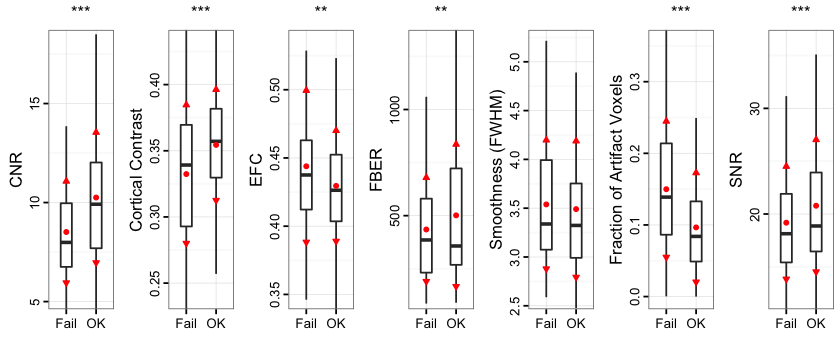

In [193]:
grid.newpage()
ncol=7
nrow=1
pushViewport(viewport(layout = grid.layout(nrow, ncol)))
vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)
#print(a, vp = vplayout(1, 1:2))  # key is to define vplayout
#print(b, vp = vplayout(2, 1))
#print(c, vp = vplayout(2, 2))
label_strings=c('CNR','Cortical Contrast','EFC','FBER','Smoothness (FWHM)','Fraction of Artifact Voxels','SNR')
pval_thresh=c(.05,.01,.001)
    
for (i in seq(1,length(measure.vars)))
{
    # get only the rows corresponding to this measure
    sdf<- df %>% filter(Measure == measure.vars[i])
    sdf_ranges <- sdf %>% 
                   group_by(qc_anat) %>% 
                     summarise(y=mean(value),y.max=mean_sdhigh(value),y.min=mean_sdlow(value)) %>% 
                         ungroup

    # get the lable and annotate to indicate statistical significance of the difference
    pval<-t.test(value~as.factor(qc_anat),data=sdf)$p.value
    
    pval_string=""
    for (pt in pval_thresh)
    {
        if(pval < pt)
        {
            pval_string=paste(pval_string,'*',sep='')
        }
        else
        {
            break    
        }
    }
    
    print(paste(label_strings[i],pval_string,sprintf('pval %e',pval)))
    
    p <- ggplot(sdf, aes(x=as.factor(qc_anat), y=value, fill=as.factor(qc_anat))) + 
        geom_boxplot(outlier.shape = NA, width=.5, fill='white') + 
        geom_point(data=sdf_ranges,aes(x=qc_anat,y=y),color="red",fill="red",size=1)+
        geom_point(data=sdf_ranges,aes(x=qc_anat,y=y.max),shape=24,color="red",fill="red",size=1)+
        geom_point(data=sdf_ranges,aes(x=qc_anat,y=y.min),shape=25,color="red",fill="red",size=1)+
        theme_bw() +
        ggtitle(pval_string)+
        xlab("")+
        ylab(label_strings[i])+
        theme(legend.position = "none",
              plot.title = element_text(family = "ArialMT",
                                         face = "plain",
                                         size = 10,
                                         vjust = 0),
              axis.text.x = element_text(family = "ArialMT",
                                         face = "plain",
                                         size = 8, 
                                         angle = 0, 
                                         hjust = 0.5),
              axis.text.y = element_text(family = "ArialMT", 
                                         face = "plain", 
                                         size = 8, 
                                         angle = 90, 
                                         hjust = 0.5),
              axis.title.y = element_text(family = "ArialMT", 
                                          face = "plain", 
                                          size = 10, 
                                          angle = 90, 
                                          vjust = 0.9),
              plot.margin = unit(c(.25, .25, 0.25, .25), 
                                 "lines")) +

        # reduce the range to between the 2% and 98% quartiles to make the plot
        # range more readible, do this without censoring so that the bars will go
        # out of frame
        coord_cartesian(ylim=with(sdf, quantile(value, probs = c(0.02,.98))))
    

    # get the location of this plot in the grid
    x=ceiling(i/ncol)
    y=((i-1) %% ncol)+1
    
    # add the plot to the grid
    print(p, vp = vplayout(x, y))
}

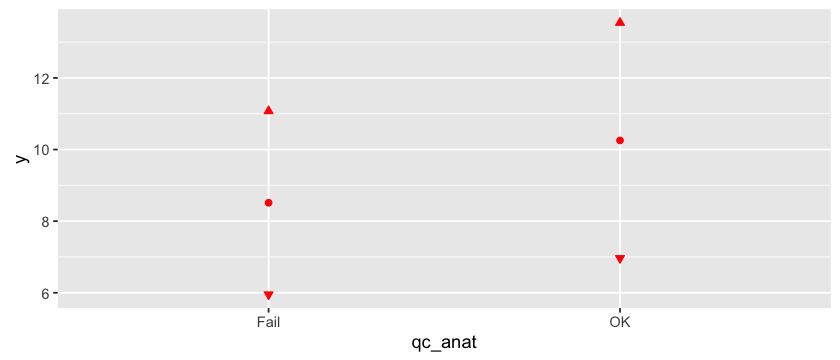

In [169]:
p1=ggplot()+
    geom_point(data=sdf_ranges,aes(x=qc_anat,y=y),color="red",fill="red")+
    geom_point(data=sdf_ranges,aes(x=qc_anat,y=y.max),shape=24,color="red",fill="red")+
    geom_point(data=sdf_ranges,aes(x=qc_anat,y=y.min),shape=25,color="red",fill="red")
print(p1)

In [113]:
i=4
sdf<- df %>% filter(Measure == measure.vars[i])
t.test(value~as.factor(qc_anat),data=sdf)
sdf %>% group_by(qc_anat) %>% summarise(avg=mean(value),sd=sd(value),q25=quantile(value,probs=(0.25)),q50=quantile(value,probs=(0.5)),q75=quantile(value,probs=(0.75)))



	Welch Two Sample t-test

data:  value by as.factor(qc_anat)
t = -3.0543, df = 292.75, p-value = 0.002463
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -109.45350  -23.67234
sample estimates:
mean in group Fail   mean in group OK 
          434.8864           501.4493 


,qc_anat,avg,sd,q25,q50,q75
1,Fail,434.886410728436,244.250138655491,231.653178865525,385.50348214805,580.05019595755
2,OK,501.449331879401,334.534785667283,268.338257593875,357.15760786555,722.5044658498


In [ ]:
plot(p[[1[]])

In [141]:
?smean.sdl


In [21]:
library(lsr)
set.seed(45)
x <- rnorm(10, 10, 1)
y <- rnorm(10, 5, 5)
cohensD(x,y)
t.test(x,y)

[1] 0.5199662


	Welch Two Sample t-test

data:  x and y
t = 1.1627, df = 9.1884, p-value = 0.2743
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.654682  8.305496
sample estimates:
mean of x mean of y 
 9.818199  6.992792 


In [112]:
sdf %>% group_by(qc_anat) %>% summarise(avg=mean(value),sd=sd(value),q25=quantile(value,probs=(0.25)),q50=quantile(value,probs=(0.5)),q75=quantile(value,probs=(0.75)))


,qc_anat,avg,sd,q25,q50,q75
1,Fail,19.1772620679905,5.32626942416134,15.41765250435,18.13440677625,21.90767288585
2,OK,20.783515046774,6.24684801809165,16.45474154165,18.867179952,23.9282242726


In [82]:
install.packages("Hmisc")

also installing the dependency ‘acepack’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [108]:
ddply(sdf, "qc_anat", summarise, avg = mean(value), sd=sd(value), q=quantile(x))

ERROR: Error in eval(expr, envir, enclos): could not find function "ddply"


In [117]:
?stat_summary

In [62]:
ungroup(means)


,qc_anat,avg
1,Fail,8.51334176030536
2,OK,10.25409805617
